In [1]:
# This cell is included to show what libraries are imported and used in the project
import matplotlib.pyplot as plt
import numpy as np
import random
import pickle
import sys
from glob import glob
import timeit

from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

%matplotlib inline

In [2]:
# This cell is included to define various functions used for computations and analysis
def error_rate(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    return 1-acc

## 1NN-DatAug (All data sets)

In [3]:
# Names of all data sets in UCR Archive
PATH = 'UCR_TS_Archive_2015/'
data_sets = []

for folder_PATH in glob(PATH+'*/'):
    
    ds = folder_PATH.split("/")[-2]
    data_sets.append(ds)
    
data_sets = np.sort(data_sets)

In [4]:
data_sets

array(['50words', 'Adiac', 'ArrowHead', 'Beef', 'BeetleFly',
       'BirdChicken', 'CBF', 'Car', 'ChlorineConcentration',
       'CinC_ECG_torso', 'Coffee', 'Computers', 'Cricket_X', 'Cricket_Y',
       'Cricket_Z', 'DiatomSizeReduction', 'DistalPhalanxOutlineAgeGroup',
       'DistalPhalanxOutlineCorrect', 'DistalPhalanxTW', 'ECG200',
       'ECG5000', 'ECGFiveDays', 'Earthquakes', 'ElectricDevices', 'FISH',
       'FaceAll', 'FaceFour', 'FacesUCR', 'FordA', 'FordB', 'Gun_Point',
       'Ham', 'HandOutlines', 'Haptics', 'Herring', 'InlineSkate',
       'InsectWingbeatSound', 'ItalyPowerDemand',
       'LargeKitchenAppliances', 'Lighting2', 'Lighting7', 'MALLAT',
       'Meat', 'MedicalImages', 'MiddlePhalanxOutlineAgeGroup',
       'MiddlePhalanxOutlineCorrect', 'MiddlePhalanxTW', 'MoteStrain',
       'NonInvasiveFatalECG_Thorax1', 'NonInvasiveFatalECG_Thorax2',
       'OSULeaf', 'OliveOil', 'PhalangesOutlinesCorrect', 'Phoneme',
       'Plane', 'ProximalPhalanxOutlineAgeGroup',
     

In [5]:
continue_run = True

if continue_run:
    with open('1NN-DatAug_performance', 'rb') as f:
        perf_table = pickle.load(f)
    ds_idx = np.where( data_sets == perf_table[-1,0] )[0][0] + 1
else:
    perf_table = np.array(['Data set', '1NN-ED', '1NN-DTW', 'MLP', 'FCN',
                           'ResNet', 'COTE', '1NN-DatAug', 'Run time'])
    ds_idx = 0

In [6]:
# Names of augmented data sets

ds_aug_list = []
for folder_PATH in glob('Augmented_data_sets/'+'*'):
    ds_aug = folder_PATH.split("/")[-1]
    ds = ds_aug.split("_")[:-1]
    ds_aug_list.append('_'.join(ds))

In [9]:
# Read previous performance results on UCR Archive
UCR_results = {}

lines = [line.rstrip('\n') for line in open('UCR_results.txt')]

for line in lines:
    ds,nn_ed,nn_dtw,mlp,fcn,resnet,cote,shape_dtw = line.split(",")
    UCR_results[ds] = ([nn_ed,nn_dtw,mlp,fcn,resnet,cote,shape_dtw])

In [10]:
for ds in data_sets[ds_idx:]:
    
    print('\n################################# ' + ds + ' #################################')
    
    perf_table_line = np.array([ds, UCR_results[ds][0], UCR_results[ds][1], UCR_results[ds][2],
                                UCR_results[ds][3], UCR_results[ds][4], UCR_results[ds][5]])
    
    if ds not in ds_aug_list:
        # Append to table
        perf_table_line = np.concatenate((perf_table_line,np.array(['/', '/'])))
        perf_table = np.row_stack((perf_table,perf_table_line))
        continue
        
    
    # Test set
    with open(PATH + ds + str('/') + ds + '_TEST', 'r') as f:
        
        test = f.read().splitlines()
        data_set_test = np.array([test[0].split(",")])
        
        for line in test[1:]:
            data_set_test = np.append(data_set_test, [line.split(",")], axis=0)
            
    # Augmented training set
    with open('Augmented_data_sets/' + ds + '_augmented', 'rb') as f:
        augmented_data_set = pickle.load(f)
    
    # Remove NanNs
    augmented_data_set = augmented_data_set[~np.isnan(augmented_data_set).any(axis=1)]

    print('Length of augmented training set: ' + str(len(augmented_data_set)))
    print(augmented_data_set)
    

    
    # --------------------------------------------------------------------------------------------



    # Set up training and test set
    train_size_aug = len(augmented_data_set)
    test_size = len(data_set_test)
    ts_length = len(data_set_test[0])-1

    X_train_aug = np.zeros((train_size_aug, ts_length))
    y_train_aug = np.zeros(train_size_aug)

    X_test = np.zeros((test_size, ts_length))
    y_test = np.zeros(test_size)

    for i in range(ts_length+1):
        # Test
        for j in range(test_size):
            if i == 0:
                y_test[j] = int(data_set_test[j][0])
            else:
                X_test[j][i-1] = float(data_set_test[j][i])
        # Augmented Train
        for j in range(train_size_aug):
            if i == 0:
                y_train_aug[j] = int(augmented_data_set[j][0])
            else:
                X_train_aug[j][i-1] = float(augmented_data_set[j][i])

    # Make sure the labels are integers
    y_test = y_test.astype(int)
    y_train_aug = y_train_aug.astype(int)

    # Make sure the labels are zero indexed
    num_classes = len(np.unique(y_test))

    idx = 0
    for label in np.unique(y_test):
        y_test[np.where( y_test == label )] = idx
        idx += 1

    # Convert labels to one-hot encoding
    y_train_aug_onehot = np.zeros((train_size_aug, num_classes))
    y_train_aug_onehot[np.arange(train_size_aug), y_train_aug] = 1



    # --------------------------------------------------------------------------------------------


    
    start_time = timeit.default_timer()

    # Train 1NN classifier
    neigh = KNeighborsClassifier(n_neighbors=1)
    neigh.fit(X_train_aug, y_train_aug)

    # Classify
    y_pred = neigh.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    err_rate = error_rate(y_test, y_pred)

    elapsed = timeit.default_timer() - start_time

    print('\nTime (with data augmentation): ' + str(elapsed))
    print('Classification accuracy: ' + str(acc))
    print('Error rate: ' + str(err_rate))



    # --------------------------------------------------------------------------------------------

    
    
    # Append and save table
    perf_table_line = np.concatenate((perf_table_line,np.array([err_rate, elapsed])))
    perf_table = np.row_stack((perf_table,perf_table_line))

    with open('1NN-DatAug_performance', 'wb') as f:
        pickle.dump(perf_table, f)


################################# 50words #################################
Length of augmented training set: 450
[[ 8.      -0.79042 -0.76517 ... -0.81473 -0.82271 -0.82133]
 [17.      -0.76406 -0.74445 ... -0.62984 -0.71135 -0.77447]
 [ 0.      -0.81704 -0.7331  ... -0.95905 -0.96174 -0.96086]
 ...
 [ 1.      -0.84612 -0.84237 ... -0.81347 -0.82807 -0.83906]
 [ 4.      -0.94585 -0.93473 ... -0.95366 -0.95704 -0.95504]
 [ 2.      -0.89936 -0.90088 ... -0.78367 -0.83933 -0.89275]]

Time (with data augmentation): 0.0516935084015131
Classification accuracy: 0.6307692307692307
Error rate: 0.36923076923076925

################################# Adiac #################################
Length of augmented training set: 99390
[[21.          1.598       1.5994     ...  1.5642      1.5709
   1.5929    ]
 [27.          1.7011      1.6706     ...  1.5197      1.6025
   1.6702    ]
 [20.          1.7223      1.6953     ...  1.6418      1.695
   1.7085    ]
 ...
 [35.          1.4228      1.3134764

KeyboardInterrupt: 

In [6]:
with open('1NN-DatAug_performance', 'wb') as f:
        pickle.dump(perf_table, f)

In [9]:
with open('1NN-DatAug_performance', 'rb') as f:
    perf_table = pickle.load(f)
    
print(perf_table)

[['Data set' '1NN-ED' '1NN-DTW' 'MLP' 'FCN' 'ResNet' 'COTE' '1NN-DatAug'
  'Run time']
 ['50words' '0.369' '0.310' '0.288' '0.321' '0.273' '0.191'
  '0.36923076923076925' '0.051604270935058594']
 ['Adiac' '0.389' '0.396' '0.248' '0.143' '0.174' '0.233'
  '0.38874680306905374' '3.186532967723906']
 ['ArrowHead' '0.200' '0.297' '0.177' '0.120' '0.183' '/'
  '0.19428571428571428' '3.6232444029301405']
 ['Beef' '0.333' '0.367' '0.167' '0.25' '0.233' '0.133'
  '0.33333333333333337' '3.3258811058476567']
 ['BeetleFly' '0.250' '0.300' '0.150' '0.050' '0.200' '/' '0.4'
  '7.084510922897607']
 ['BirdChicken' '0.450' '0.250' '0.200' '0.050' '0.100' '/'
  '0.19999999999999996' '5.899353120010346']
 ['CBF' '0.148' '0.003' '0.14' '0' '0.006' '0.001' '0.004444444444444473'
  '19.557911437936127']
 ['Car' '0.267' '0.267' '0.167' '0.083' '0.067' '/' '0.33333333333333337'
  '4.905198831111193']
 ['ChlorineConcentration' '0.35' '0.352' '0.128' '0.157' '0.172' '0.314'
  '0.3526041666666667' '5.4865281069

## Learning curve as a function of data points

In [5]:
PATH = 'UCR_TS_Archive_2015/'
ds = 'DistalPhalanxTW' #BirdChicken

In [6]:
# Test set
with open(PATH + ds + str('/') + ds + '_TEST', 'r') as f:

    test = f.read().splitlines()
    data_set_test = np.array([test[0].split(",")])

    for line in test[1:]:
        data_set_test = np.append(data_set_test, [line.split(",")], axis=0)

# Augmented training set
with open('Augmented_data_sets/' + ds + '_augmented', 'rb') as f:
    augmented_data_set = pickle.load(f)

# Remove NanNs
augmented_data_set = augmented_data_set[~np.isnan(augmented_data_set).any(axis=1)]

print('Length of augmented training set: ' + str(len(augmented_data_set)))
print(augmented_data_set)

Length of augmented training set: 99139
[[ 1.         -0.81367    -0.74423    ... -0.9129     -0.58573
  -0.37801   ]
 [ 3.         -0.9176     -0.76556    ... -0.88117    -0.65265
  -0.36349   ]
 [ 5.         -0.461      -0.39871    ... -1.0794     -1.0794
  -1.0794    ]
 ...
 [ 2.         -1.139      -0.72908099 ... -0.62470088 -0.42349991
  -0.22483   ]
 [ 2.         -0.90472    -0.27504854 ... -0.97020905 -0.61906772
  -0.25032   ]
 [ 5.         -0.45398    -0.32086228 ... -1.0987     -1.0987
  -1.0987    ]]


In [7]:
# Set up training and test set
train_size_aug = len(augmented_data_set)
test_size = len(data_set_test)
ts_length = len(data_set_test[0])-1

X_train_aug = np.zeros((train_size_aug, ts_length))
y_train_aug = np.zeros(train_size_aug)

X_test = np.zeros((test_size, ts_length))
y_test = np.zeros(test_size)

for i in range(ts_length+1):
    # Test
    for j in range(test_size):
        if i == 0:
            y_test[j] = int(data_set_test[j][0])
        else:
            X_test[j][i-1] = float(data_set_test[j][i])
    # Train
    for j in range(train_size_aug):
        if i == 0:
            y_train_aug[j] = int(augmented_data_set[j][0])
        else:
            X_train_aug[j][i-1] = float(augmented_data_set[j][i])

# Make sure the labels are integers
y_test = y_test.astype(int)
y_train_aug = y_train_aug.astype(int)

# Make sure the labels are zero indexed
num_classes = len(np.unique(y_test))

idx = 0
for label in np.unique(y_test):
    y_test[np.where( y_test == label )] = idx
    idx += 1

# Convert labels to one-hot encoding
y_train_aug_onehot = np.zeros((train_size_aug, num_classes))
y_train_aug_onehot[np.arange(train_size_aug), y_train_aug] = 1

In [ ]:
# Find error rate as a function of training points

num_points2 = np.linspace(10, train_size_aug, num=50, dtype=np.int32)

err_rates_train2 = []
err_rates2 =  []

for N in num_points2:
    
    # Train 1NN classifier
    neigh = KNeighborsClassifier(n_neighbors=1)
    neigh.fit(X_train_aug[:N], y_train_aug[:N])

    # Classify on test
    y_pred = neigh.predict(X_test)
    err_rates2.append(error_rate(y_test, y_pred))
    
    # Classify on train
    y_pred = neigh.predict(X_train_aug)
    err_rates_train2.append(error_rate(y_train_aug, y_pred))

    print('Completed ' + str(N) + ' classifications')

Completed 10 classifications
Completed 2033 classifications
Completed 4056 classifications
Completed 6079 classifications
Completed 8102 classifications
Completed 10125 classifications
Completed 12148 classifications
Completed 14171 classifications
Completed 16194 classifications
Completed 18217 classifications
Completed 20240 classifications
Completed 22263 classifications
Completed 24286 classifications
Completed 26309 classifications
Completed 28332 classifications
Completed 30355 classifications
Completed 32378 classifications
Completed 34401 classifications
Completed 36424 classifications
Completed 38447 classifications
Completed 40470 classifications
Completed 42493 classifications
Completed 44516 classifications
Completed 46539 classifications
Completed 48562 classifications
Completed 50586 classifications
Completed 52609 classifications


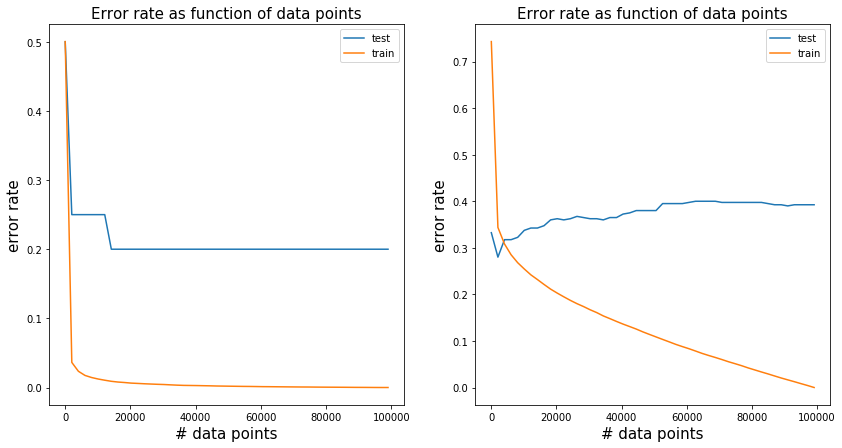

In [51]:
# Plot error rate as a function of training points
title_size = 20
plt.figure(figsize=(14, 7))

max_idx = len(num_points)

plt.subplot(121)
plt.plot(num_points[:max_idx], err_rates[:max_idx], label='test')
plt.plot(num_points[:max_idx], err_rates_train[:max_idx], label='train')
plt.title('BirdChicken', fontsize=title_size)
plt.ylabel('error rate', fontsize=title_size)
plt.xlabel('# data points', fontsize=title_size)
plt.legend(loc='upper right')

plt.subplot(122)
plt.plot(num_points2[:max_idx], err_rates2[:max_idx], label='test')
plt.plot(num_points2[:max_idx], err_rates_train2[:max_idx], label='train')
plt.title('DistalPhalanxTW', fontsize=title_size)
plt.ylabel('error rate', fontsize=title_size)
plt.xlabel('# data points', fontsize=title_size)
plt.legend(loc='upper right')

plt.subplots_adjust(wspace=0.2, hspace=0)

#plt.savefig("data_learning_rate2.eps", bbox_inches='tight')
plt.show()

## Learning curves

In [ ]:
ds = 'DistalPhalanxTW'

# Training set
with open(PATH + ds + str('/') + ds + '_TRAIN', 'r') as f:

    train = f.read().splitlines()
    data_set_train = np.array([train[0].split(",")])

    for line in train[1:]:
        data_set_train = np.append(data_set_train, [line.split(",")], axis=0)
        
# Test set
with open(PATH + ds + str('/') + ds + '_TEST', 'r') as f:

    test = f.read().splitlines()
    data_set_test = np.array([test[0].split(",")])

    for line in test[1:]:
        data_set_test = np.append(data_set_test, [line.split(",")], axis=0)

# Augmented training set
with open('Augmented_data_sets/' + ds + '_augmented', 'rb') as f:
    augmented_data_set = pickle.load(f)

# Remove NanNs
augmented_data_set = augmented_data_set[~np.isnan(augmented_data_set).any(axis=1)]

print('Length of augmented training set: ' + str(len(augmented_data_set)))
print(augmented_data_set)

In [ ]:
# Set up training and test set
train_size = len(data_set_train)
train_size_aug = len(augmented_data_set)
test_size = len(data_set_test)
ts_length = len(data_set_test[0])-1

X_train = np.zeros((train_size, ts_length))
y_train = np.zeros(train_size)

X_train_aug = np.zeros((train_size_aug, ts_length))
y_train_aug = np.zeros(train_size_aug)

X_test = np.zeros((test_size, ts_length))
y_test = np.zeros(test_size)

for i in range(ts_length+1):
    # Train
    for j in range(train_size):
        if i == 0:
            y_train[j] = int(data_set_train[j][0])
        else:
            X_train[j][i-1] = float(data_set_train[j][i])
    # Test
    for j in range(test_size):
        if i == 0:
            y_test[j] = int(data_set_test[j][0])
        else:
            X_test[j][i-1] = float(data_set_test[j][i])
    # Augmented Train
    for j in range(train_size_aug):
        if i == 0:
            y_train_aug[j] = int(augmented_data_set[j][0])
        else:
            X_train_aug[j][i-1] = float(augmented_data_set[j][i])

# Make sure the labels are integers
y_train = y_train.astype(int)
y_test = y_test.astype(int)
y_train_aug = y_train_aug.astype(int)

# Make sure the labels are zero indexed
num_classes = len(np.unique(y_test))

idx = 0
for label in np.unique(y_test):
    y_train[np.where( y_train == label )] = idx
    y_test[np.where( y_test == label )] = idx
    idx += 1

# Convert labels to one-hot encoding
y_train_onehot = np.zeros((train_size, num_classes))
y_train_onehot[np.arange(train_size), y_train] = 1

y_train_aug_onehot = np.zeros((train_size_aug, num_classes))
y_train_aug_onehot[np.arange(train_size_aug), y_train_aug] = 1

In [ ]:
# Reset tensorflow graph
tf.reset_default_graph()
sess = tf.InteractiveSession()

# Setup model
model = FCN(ts_length, num_classes)

# Set up data for Tensorflow model
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
y_train_onehot = np.reshape(y_train_onehot,(train_size, num_classes))

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.01)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(X_train, y_train_onehot,
                    batch_size=batch_size,
                    epochs=200,
                    validation_split=validation_split,
                    shuffle=True,
                    verbose=1)

In [ ]:
# list all data in history
print(history.history.keys())
title_size = 15

plt.figure(figsize=(14, 7))

# summarize history for accuracy
plt.subplot(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy', fontsize=title_size)
plt.ylabel('accuracy', fontsize=title_size)
plt.xlabel('epoch', fontsize=title_size)
plt.legend(['train', 'val'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss', fontsize=title_size)
plt.ylabel('loss', fontsize=title_size)
plt.xlabel('epoch', fontsize=title_size)
plt.legend(['train', 'val'], loc='upper left')

plt.subplots_adjust(wspace=0.15, hspace=0)

#plt.savefig("fcn_learning_rate.eps", bbox_inches='tight')

plt.show()

In [ ]:
# Reset tensorflow graph
tf.reset_default_graph()
sess = tf.InteractiveSession()

# Setup model
model = FCN(ts_length, num_classes)

# Set up data for Tensorflow model
X_train_aug = np.reshape(X_train_aug,(X_train_aug.shape[0],X_train_aug.shape[1],1))
y_train_aug_onehot = np.reshape(y_train_aug_onehot,(train_size_aug, num_classes))

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.01)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history_aug = model.fit(X_train_aug, y_train_aug_onehot,
                    batch_size=batch_size,
                    epochs=200,
                    validation_split=validation_split,
                    shuffle=True,
                    verbose=1)

In [ ]:
# list all data in history
print(history_aug.history.keys())

plt.figure(figsize=(14, 7))

# summarize history for accuracy
plt.subplot(121)
plt.plot(history_aug.history['acc'])
plt.plot(history_aug.history['val_acc'])
plt.title('model accuracy (data augmentation)', fontsize=title_size)
plt.ylabel('accuracy', fontsize=title_size)
plt.xlabel('epoch', fontsize=title_size)
plt.legend(['train', 'val'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(history_aug.history['loss'])
plt.plot(history_aug.history['val_loss'])
plt.title('model loss (data augmentation)', fontsize=title_size)
plt.ylabel('loss', fontsize=title_size)
plt.xlabel('epoch', fontsize=title_size)
plt.legend(['train', 'val'], loc='upper left')

plt.subplots_adjust(wspace=0.15, hspace=0)

plt.savefig("fcn_learning_rate_aug.eps", bbox_inches='tight')

plt.show()